In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.dates as mdates

# sklearn imports
from sklearn.model_selection import train_test_split

# oma_tracking imports
from oma_tracking.data.preprocessing import sin_cos_angle_inputs

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import DatasetGetter
from oma_tracking.data.utils import unpack_mode, get_frequencies, get_rated_data, get_parked_data, read_simulations_csv_files

In [3]:
start  = datetime.datetime(2012,1,1,tzinfo=utc)
stop  = datetime.datetime(2023,7,19,tzinfo=utc)

location = 'bbc01'
name_location = 'BB_C01'

home_folder = "../../"
data_file_name = '_'.join([location, start.strftime("%Y%m%d"), stop.strftime("%Y%m%d")])
data_path = home_folder + "data/bb/raw/" + data_file_name + ".parquet"
data = pd.read_parquet(data_path)


SS1 = get_frequencies(data, 'SS1')
SS2 = get_frequencies(data, 'SS2')
FA1 = get_frequencies(data, 'FA1')

In [4]:
weather_data_path = "../../data/nw2/mvbc_data_longterm.parquet"
Thorntonbank_data_path = "../../data/nw2/Thorntonbank_data_longterm.parquet"
Westhinder_data_path = "../../data/nw2/Westhinder_data_longterm.parquet"

weather_data = pd.read_parquet(weather_data_path)

scada_inputs = data.filter(regex='mean')

inputs = \
    pd.concat(
        [
            weather_data,
            scada_inputs
        ],
        axis=1
    )

selected_columns = \
    [
       'Sea_water_temperature',
       'Wave_height',
       'Tide_TAW',
       'Average_wave_period',
       'Air_pressure',
       'Air_temperature',
       'mean_'+ name_location + '_rpm',
       'mean_'+ name_location + '_yaw',
       'mean_'+ name_location + '_pitch',
       'mean_'+ name_location + '_power',
       'mean_'+ name_location + '_windspeed',
       'mean_'+ name_location + '_winddirection'
    ]
inputs = inputs[selected_columns]

C:\Users\Max\AppData\Local\Temp\ipykernel_4328\1052292621.py:134: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar.draw_all()


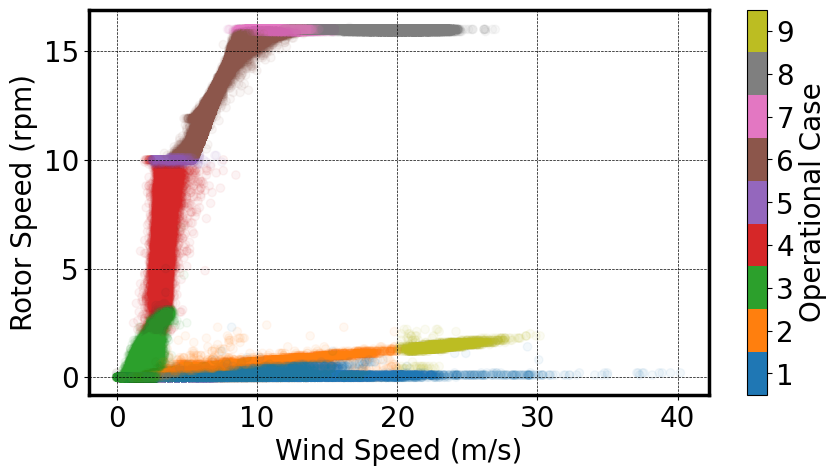

In [5]:
### Multiple Linear Regression
# define the 6 operational cases

inputs['operational_case'] = np.nan

cutout_windspeed = 25
windspeed5 = 5
windspeed20 = 20
windspeed2_5 = 2.5
windspeed7_5 = 7.5
windspeed15_5 = 15.5

pitch_1 = -1
pitch19 = 19
pitch19_5 = 19.5
pitch20_5 = 20.5
pitch70 = 70
pitch80 = 80
pitch100 = 100
pitch_20 = -20
pitch1 = 1
pitch70 = 70

rpm2_5 = 2.5
rpm10 = 10
rpm2_05 = 2.05
rpm9_8 = 9.8
rpm10_2 = 10.2
rpm15_9 = 15.9
rpm17 = 17
rpm2_2 = 2.2

power2950 = 2950
power2920 = 2920

# Case 1: parked
inputs['operational_case'] = np.where(
    (inputs.filter(regex='rpm') <= rpm2_5).values[:,0] \
    & (inputs.filter(regex='pitch') >= pitch80).values[:,0] \
    & (inputs.filter(regex='pitch') <= pitch100).values[:,0],
    1,
    inputs['operational_case']
)

# Case 2: pitch:80
inputs['operational_case'] = np.where(
    (inputs.filter(regex='rpm') <= rpm2_5).values[:,0] \
    & (inputs.filter(regex='pitch') >= pitch70).values[:,0] \
    & (inputs.filter(regex='pitch') <= pitch80).values[:,0] \
    & (inputs.filter(regex='windspeed') <= windspeed20).values[:,0],
    2,
    inputs['operational_case']
)

# Case 3: pitch:20
inputs['operational_case'] = np.where(
    (inputs.filter(regex='pitch') >= pitch19_5).values[:,0] \
    & (inputs.filter(regex='pitch') <= pitch20_5).values[:,0] \
    & (inputs.filter(regex='windspeed') <= windspeed5).values[:,0],
    3,
    inputs['operational_case']
)

# Case 4: rpm<10
inputs['operational_case'] = np.where(
    (inputs.filter(regex='rpm') >= rpm2_05).values[:,0] \
    & (inputs.filter(regex='rpm') <= rpm10).values[:,0] \
    & (inputs.filter(regex='pitch') >= pitch_1).values[:,0] \
    & (inputs.filter(regex='pitch') <= pitch19).values[:,0],
    4,
    inputs['operational_case']
)

# Case 5: rpm:10
inputs['operational_case'] = np.where(
    (inputs.filter(regex='rpm') >= rpm9_8).values[:,0] \
    & (inputs.filter(regex='rpm') <= rpm10_2).values[:,0] \
    & (inputs.filter(regex='windspeed') >= windspeed2_5).values[:,0] \
    & (inputs.filter(regex='windspeed') <= windspeed7_5).values[:,0],
    5,
    inputs['operational_case']
)

# Case 6: rpm<16
inputs['operational_case'] = np.where(
    (inputs.filter(regex='rpm') >= rpm10_2).values[:,0] \
    & (inputs.filter(regex='rpm') <= rpm15_9).values[:,0] \
    & (inputs.filter(regex='pitch') > pitch_20).values[:,0] \
    & (inputs.filter(regex='pitch') < pitch1).values[:,0],
    6,
    inputs['operational_case']
)

# Case 7: Rated RPM
inputs['operational_case'] = np.where(
    (inputs.filter(regex='rpm') >= rpm15_9).values[:,0] \
    & (inputs.filter(regex='rpm') <= rpm17).values[:,0] \
    & (inputs.filter(regex='windspeed') <= windspeed15_5).values[:,0] \
    & (inputs.filter(regex='power') <= power2950).values[:,0],
    7,
    inputs['operational_case']
)

# Case 8: Rated Power
inputs['operational_case'] = np.where(
    (inputs.filter(regex='rpm') >= rpm15_9).values[:,0] \
    & (inputs.filter(regex='rpm') <= rpm17).values[:,0] \
    & (inputs.filter(regex='power') >= power2920).values[:,0],
    8,
    inputs['operational_case']
)

# Case 9: Cutout
inputs['operational_case'] = np.where(
    (inputs.filter(regex='pitch') > pitch70).values[:,0] \
    & (inputs.filter(regex='pitch') < pitch80).values[:,0] \
    & (inputs.filter(regex='windspeed') > windspeed20).values[:,0] \
    & (inputs.filter(regex='rpm') <= rpm2_2).values[:,0],
    9,
    inputs['operational_case']
)

import matplotlib

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(10, 5))
cmap = matplotlib.colors.ListedColormap(plt.cm.tab10.colors[:len(inputs['operational_case'].unique())-1])
plt.scatter(inputs.filter(regex='windspeed').values[:,0], inputs.filter(regex='rpm').values[:,0], alpha=0.05, c=inputs['operational_case'], cmap=cmap)
# Add the colorbar with alpha = 1
cbar = plt.colorbar()
cbar.ax.set_ylabel('Operational Case')
cbar.set_alpha(1)
cbar.draw_all()
tick_locs = np.linspace(int(inputs['operational_case'].min()), int(inputs['operational_case'].max()), int(2 * len(inputs['operational_case'].unique()) -1 ))[1::2]
cbar_tick_label = np.arange(int(inputs['operational_case'].min()), int(inputs['operational_case'].max() + 1))
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(cbar_tick_label)

# Increase the width of the spines
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['top'].set_linewidth(2.5)

plt.grid(True, color='k', linestyle='--', linewidth=0.5)

plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Rotor Speed (rpm)')
plt.show()

In [6]:
parked_data = get_parked_data(data)
parked_SS2 = get_frequencies(parked_data, 'SS2')
days = parked_SS2.groupby(parked_SS2.index.date).count()[parked_SS2.groupby(parked_SS2.index.date).count() > 144*0.2].dropna().index
parked_SS2['date'] = parked_SS2.index.date
parked_SS2_longterm = parked_SS2[np.isin(parked_SS2['date'], days)].drop(columns=['date'])

In [7]:
from sklearn.cluster import DBSCAN

time_difference = (parked_SS2_longterm.index-parked_SS2_longterm.index[0]).total_seconds()/60
parked_SS2_longterm['time_difference'] = time_difference
clustering = DBSCAN(eps=60*24*14, min_samples=2).fit(parked_SS2_longterm['time_difference'].values.reshape(-1, 1) )
parked_SS2_longterm['cluster'] = clustering.labels_

In [8]:
big_clusters = parked_SS2_longterm.groupby('cluster').count()[parked_SS2_longterm.groupby('cluster').count()>144].dropna().index
parked_SS2_longterm_big_clusters = parked_SS2_longterm[np.isin(parked_SS2_longterm['cluster'], big_clusters)]
unique_vals = parked_SS2_longterm_big_clusters['cluster'].unique()
parked_SS2_longterm_big_clusters['cluster'].replace(to_replace=unique_vals,
           value= list(range(len(unique_vals))), inplace=True)

C:\Users\Max\AppData\Local\Temp\ipykernel_4328\1882412710.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parked_SS2_longterm_big_clusters['cluster'].replace(to_replace=unique_vals,


In [9]:
# sklearn imports
from sklearn.model_selection import train_test_split

# oma_tracking imports
from oma_tracking.data.preprocessing import sin_cos_angle_inputs

random_state = 24
test_size = 0.2
angle_transformed_inputs = sin_cos_angle_inputs(inputs)
angle_columns = [angle for angle in inputs.columns if ('yaw' in angle or 'winddirection' in angle)]
angle_removed_inputs = inputs.drop(columns=angle_columns)

prediction_param = parked_SS2_longterm_big_clusters.copy()
y = prediction_param.dropna()
X = angle_transformed_inputs.loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=test_size, random_state=random_state)

from sklearn.preprocessing import StandardScaler
def data_preprocessing(X_train, X_test):
    "Apply standard scaling to the data"
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    return X_train, X_test
    
X_tr_prep, X_test_prep = data_preprocessing(X_train, X_test) 

2.0
(5253, 12) (5253,)
R2:  0.5547244044134154 MSE:  0.0003489057679095431
1.0
(8607, 12) (8607,)
R2:  0.5533189014061088 MSE:  0.0002861312088777817
9.0
(205, 12) (205,)
R2:  0.4647965164285415 MSE:  0.00012253823441013589
Overall R2:  0.5525535987667188
Overall MSE:  0.0003071918700102364


C:\Users\Max\AppData\Local\Temp\ipykernel_4328\1558054514.py:60: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_ts = pd.Series()
C:\Users\Max\AppData\Local\Temp\ipykernel_4328\1558054514.py:61: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_test_ts = pd.Series()
C:\Users\Max\AppData\Local\Temp\ipykernel_4328\1558054514.py:62: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_full_ts = pd.Series()


14068 2814
R2:  0.593727941405557


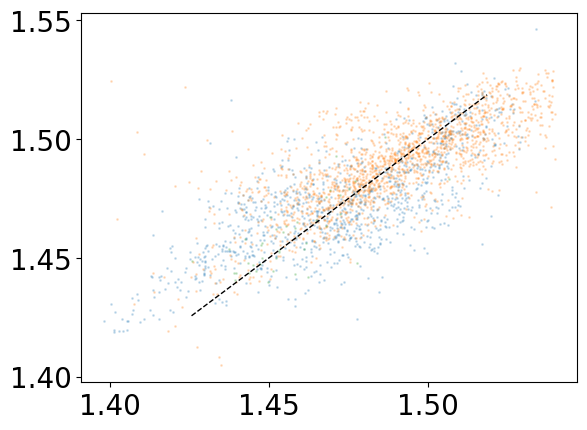

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
mode = 'SS1'
df = inputs.copy().loc[X.index].dropna()
random_state = 24
test_size = 0.2

prediction_param = parked_SS2_longterm_big_clusters.copy()['mean_frequency']



# Train Linear Regression Models for Each Case

linear_regression_models = {}
predictions = {}
r2 = {}
mean_squared_errors = {}
y = prediction_param.dropna()
common_indices = df.index.intersection(y.index)
df_case = df.loc[common_indices]
y_test_cases = {}
predictions_full = {}

operational_cases = df['operational_case'].unique()

for case in operational_cases:
    print(case)
    
    # Filter the dataset for the current operational case
    case_data = df_case[df_case['operational_case'] == case]
    
    # Split the data into input features (X) and target variable (y)
    y = prediction_param.dropna()
    X = case_data.drop(['operational_case'], axis=1).dropna()
    y = y.loc[X.index]
    print(X.shape, y.shape)
    
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=test_size, random_state=random_state)
    y_test_cases[case] = y_test
    # Train a linear regression model for the current case
    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)
    
    # Store the trained linear regression model for the current case
    linear_regression_models[case] = linear_regression
    linear_regression_models[case].predict(X_test)
    predictions[case] = pd.Series(linear_regression_models[case].predict(X_test), index=y_test.index)
    predictions_full[case] = pd.Series(linear_regression_models[case].predict(X), index=y.index)

    r2[case] = r2_score(y_test, predictions[case])
    mean_squared_errors[case] = mean_squared_error(y_test, predictions[case])
    print('R2: ', r2[case], 'MSE: ', mean_squared_errors[case])
    plt.scatter(y_test, predictions[case], alpha=0.2, s=1)
plt.plot(np.arange(y.values.min(),y.values.max(),0.001), np.arange(y.values.min(),y.values.max(),0.001), c='k', linestyle='--', linewidth=1)
# Calculate the overall R2 and MSE for the linear regression model through weighted averaging
r2_overall = 0
mse_overall = 0
predictions_ts = pd.Series()
y_test_ts = pd.Series()
predictions_full_ts = pd.Series()
for case in operational_cases:
    r2_overall += r2[case] * len(df_case[df_case['operational_case'] == case])
    mse_overall += mean_squared_errors[case] * len(df_case[df_case['operational_case'] == case])
    predictions_ts = pd.concat([predictions_ts, predictions[case]])
    y_test_ts = pd.concat([y_test_ts, y_test_cases[case]])
    predictions_full_ts = pd.concat([predictions_full_ts, predictions_full[case]])
y_test_ts = y_test_ts
r2_overall /= len(df_case)
mse_overall /= len(df_case)

print('Overall R2: ', r2_overall)
print('Overall MSE: ',mse_overall)


y = prediction_param.dropna()
X = inputs.copy().drop(['operational_case'], axis=1).loc[y.index].dropna()
y = y.loc[X.index]

predictions_ts.sort_index(inplace=True)
predictions_full_ts.sort_index(inplace=True)
y_test_ts.sort_index(inplace=True)
print(len(y.values), len(predictions_ts.values))
test_ts = pd.DataFrame({'y_test': y_test_ts.values, 'predictions': predictions_ts.values}).dropna()
#test_full_ts = pd.DataFrame({'y': y.values[:,0], 'predictions': predictions_full_ts.values}).dropna()
print('R2: ', r2_score(test_ts['y_test'], test_ts['predictions']))
#print('R2: ', r2_score(test_full_ts['y'], test_full_ts['predictions']))

In [11]:
y_test_mask = y.isin(y_test_ts)
y_tr_mask = ~y_test_mask
y_tr_ts = y[y_tr_mask].dropna()
X_tr_ts = X.loc[y_tr_ts.index]
X_test_ts = X.loc[y_test_ts.index]

X_tr_ts_prep, X_test_ts_prep = data_preprocessing(X_tr_ts, X_test_ts)
y_tr_ts_prep, y_test_ts_prep = y_tr_ts.loc[X_tr_ts_prep.index], y_test_ts.loc[X_test_ts_prep.index]

In [12]:
lin_regr = LinearRegression()
lin_regr.fit(X_tr_ts_prep, y_tr_ts_prep)

LinearRegression()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MSE:  0.00035155224492163266 R2:  0.5350619623249282


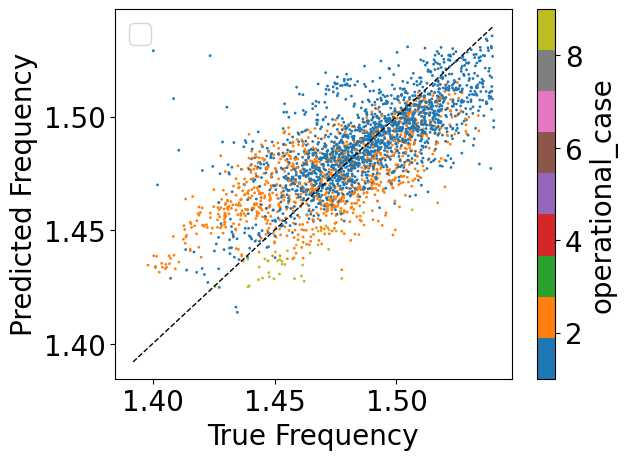

In [13]:
color_column = 'operational_case'

lin_regr = LinearRegression()
lin_regr.fit(X_tr_ts_prep, y_tr_ts_prep)

lin_regr_pred = lin_regr.predict(X_test_ts_prep)

mse = mean_squared_error(y_test_ts_prep, lin_regr_pred)
r2 = r2_score(y_test_ts_prep, lin_regr_pred)
print('MSE: ', mse, 'R2: ', r2)

plt.plot(np.arange(y.values.min(),y.values.max(),0.001), np.arange(y.values.min(),y.values.max(),0.001), c='k', linestyle='--', linewidth=1)
plt.scatter(
    y_test_ts_prep, lin_regr_pred, alpha=1, s=1, c=inputs[color_column].loc[y_test_ts_prep.index], cmap=cmap,
    )
plt.colorbar(label=color_column)
plt.xlabel('True Frequency')
plt.ylabel('Predicted Frequency')
plt.legend()

In [14]:
import xgboost as xgb
prediction_param = parked_SS2_longterm_big_clusters.copy()['mean_frequency']
y = prediction_param.dropna()
X = angle_transformed_inputs.loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=test_size, random_state=random_state)

xgb_regr = xgb.XGBRegressor()
xgb_regr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MSE:  8.873391697986684e-05 R2:  0.8805780593594064


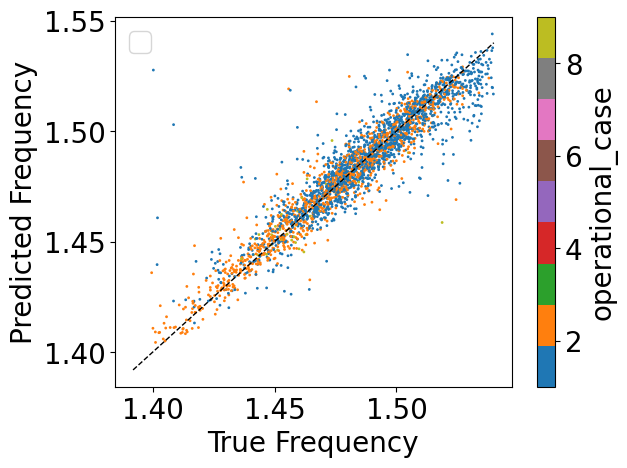

In [15]:
import matplotlib

color_column = 'operational_case'
cmap = matplotlib.colors.ListedColormap(plt.cm.tab10.colors[:len(inputs['operational_case'].unique())-1])

xgb_regressor_pred = xgb_regr.predict(X_test)

mse = mean_squared_error(y_test, xgb_regressor_pred)
r2 = r2_score(y_test, xgb_regressor_pred)
print('MSE: ', mse, 'R2: ', r2)

plt.plot(np.arange(y.values.min(),y.values.max(),0.001), np.arange(y.values.min(),y.values.max(),0.001), c='k', linestyle='--', linewidth=1)
plt.scatter(
    y_test, xgb_regressor_pred, alpha=1, s=1, c=X_test[color_column], cmap=cmap,
    )
plt.colorbar(label=color_column)
plt.xlabel('True Frequency')
plt.ylabel('Predicted Frequency')
plt.legend()

In [16]:
# Catboost
import catboost as cb
cb_reg_1 = cb.CatBoostRegressor(task_type='GPU', verbose=200)
cb_reg_1.fit(X_train, y_train)

Learning rate set to 0.055466
0:	learn: 0.0262129	total: 740ms	remaining: 12m 19s
200:	learn: 0.0088381	total: 1m 30s	remaining: 5m 58s
400:	learn: 0.0083536	total: 3m 2s	remaining: 4m 32s
600:	learn: 0.0081874	total: 4m 47s	remaining: 3m 10s
800:	learn: 0.0080876	total: 6m 54s	remaining: 1m 42s
999:	learn: 0.0079921	total: 8m 35s	remaining: 0us


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CB MSE: 8.237879161436013e-05 CB R2: 0.8891310617512119


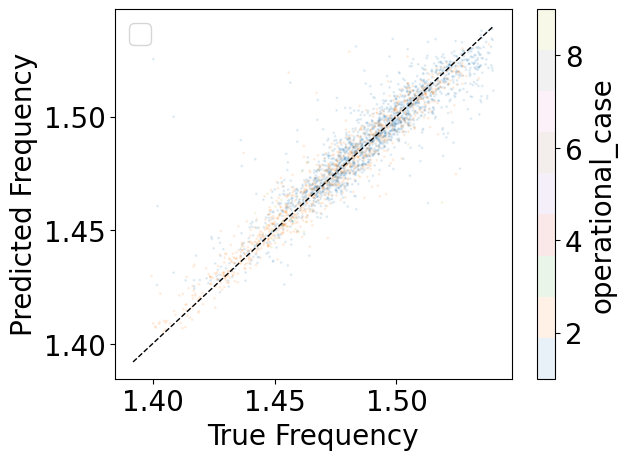

In [17]:
cb_preds = cb_reg_1.predict(X_test)
cb_mse = mean_squared_error(y_test, cb_preds)
cb_r2 = r2_score(y_test, cb_preds)
print("CB MSE:", cb_mse, "CB R2:", cb_r2)

plt.plot(np.arange(y.values.min(),y.values.max(),0.001), np.arange(y.values.min(),y.values.max(),0.001), c='k', linestyle='--', linewidth=1)
plt.scatter(
    y_test, cb_preds, alpha=0.1, s=1, c=X_test[color_column], cmap=cmap,
    )
plt.colorbar(label=color_column)
plt.xlabel('True Frequency')
plt.ylabel('Predicted Frequency')
plt.legend()

-0.00018546366072696532
0.009074381237578123


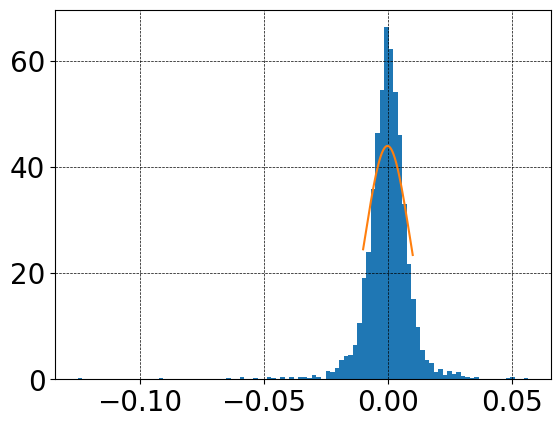

In [18]:
from scipy.stats import norm
residual = y_test.values  - cb_preds
print(np.mean(residual))
print(np.std(residual))
plt.hist(residual, bins=100, density=True)
x_axis = np.arange(-0.01, 0.01, 1e-7)
plt.plot(x_axis, norm.pdf(x_axis, np.mean(residual), np.std(residual)))
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
plt.show()

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf_regr = RandomForestRegressor()
rf_regr.fit(X_tr_ts, y_tr_ts)

RandomForestRegressor()

rf MSE: 9.126748457199892e-05 rf R2: 0.8792961052207068


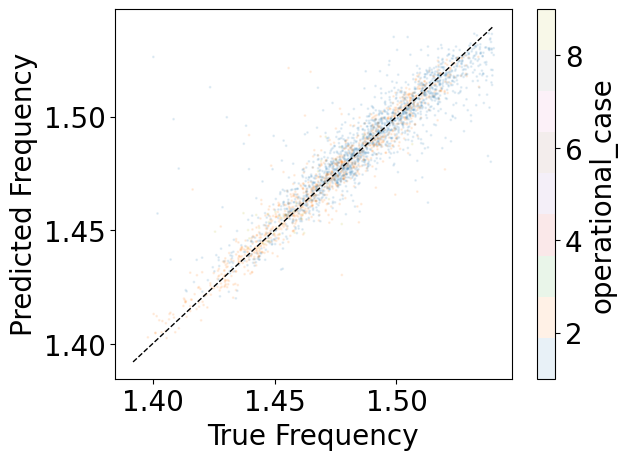

In [20]:
rf_predictions = rf_regr.predict(X_test_ts)
rf_mse = mean_squared_error(y_test_ts, rf_predictions)
rf_r2 = r2_score(y_test_ts, rf_predictions)
print("rf MSE:", rf_mse, "rf R2:", rf_r2)

plt.plot(np.arange(y.values.min(),y.values.max(),0.001), np.arange(y.values.min(),y.values.max(),0.001), c='k', linestyle='--', linewidth=1)
plt.scatter(
    y_test_ts, rf_predictions, alpha=0.1, s=1, c=inputs[color_column].loc[y_test_ts.index], cmap=cmap,
    )
plt.colorbar(label=color_column)
plt.xlabel('True Frequency')
plt.ylabel('Predicted Frequency')
plt.show()

In [21]:
from tensorflow import keras
from keras import layers

keras_nn = keras.Sequential()
keras_nn.add(layers.Flatten())
keras_nn.add(
        layers.Dense(
            # Define the hyperparameter.
            units=32,
            activation="relu",
        )
    )
keras_nn.add(layers.Dense(1, activation="linear"))
keras_nn.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"],
    )

In [22]:
keras_nn.fit(X_tr_ts_prep, y_tr_ts_prep, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
352/352 [==============================] - 2s 2ms/step - loss: 0.4092 - mean_squared_error: 0.4092
Epoch 2/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0387 - mean_squared_error: 0.0387
Epoch 3/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0206 - mean_squared_error: 0.0206
Epoch 4/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 5/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 6/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 7/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 8/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 9/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0030 - mean_squared_error: 0.0030
E

NN MSE: 0.0001431880423926568 NN R2: 0.8106296619911578


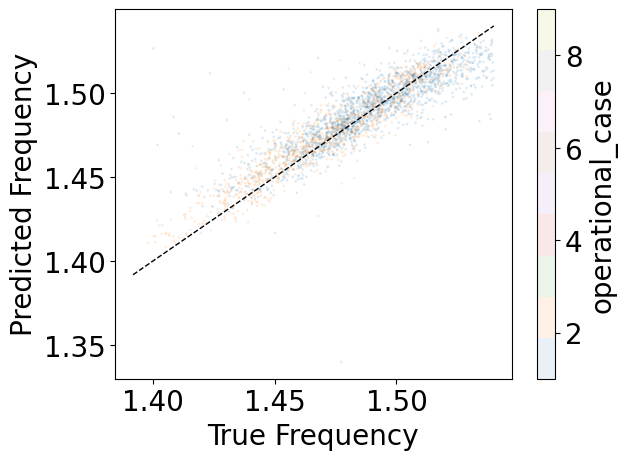

In [23]:
nn_predictions = keras_nn.predict(X_test_ts_prep)
nn_mse = mean_squared_error(y_test_ts_prep, nn_predictions)
nn_r2 = r2_score(y_test_ts_prep, nn_predictions)
print("NN MSE:", nn_mse, "NN R2:", nn_r2)

plt.plot(np.arange(y.values.min(),y.values.max(),0.001), np.arange(y.values.min(),y.values.max(),0.001), c='k', linestyle='--', linewidth=1)
plt.scatter(
    y_test_ts_prep, nn_predictions, alpha=0.1, s=1,c=inputs[color_column].loc[y_test_ts_prep.index], cmap=cmap,
    )
plt.colorbar(label=color_column)
plt.xlabel('True Frequency')
plt.ylabel('Predicted Frequency')
plt.show()

In [24]:
from tensorflow import keras
from keras import layers

keras_nn2 = keras.Sequential()
keras_nn2.add(layers.Flatten())
keras_nn2.add(
        layers.Dense(
            # Define the hyperparameter.
            units=32,
            activation="relu",
        )
    )
keras_nn2.add(
        layers.Dense(
            # Define the hyperparameter.
            units=32,
            activation="relu",
        )
    )
keras_nn2.add(layers.Dense(1, activation="linear"))
keras_nn2.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"],
    )
keras_nn2.fit(X_tr_ts_prep, y_tr_ts_prep, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
352/352 [==============================] - 2s 2ms/step - loss: 0.1533 - mean_squared_error: 0.1533
Epoch 2/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0143 - mean_squared_error: 0.0143
Epoch 3/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 4/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 5/100
352/352 [==============================] - 1s 3ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 6/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 7/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 8/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 9/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0014 - mean_squared_error: 0.0014
E

NN MSE: 0.00011478370645413304 NN R2: 0.8481952198946913


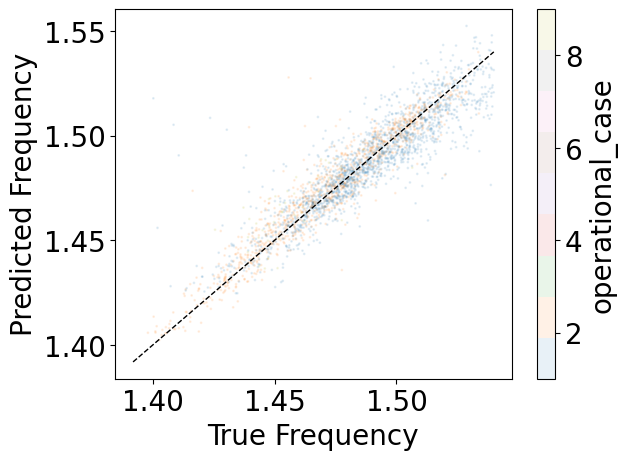

In [25]:
nn2_predictions = keras_nn2.predict(X_test_ts_prep)
nn2_mse = mean_squared_error(y_test_ts_prep, nn2_predictions)
nn2_r2 = r2_score(y_test_ts_prep, nn2_predictions)
print("NN MSE:", nn2_mse, "NN R2:", nn2_r2)

plt.plot(np.arange(y.values.min(),y.values.max(),0.001), np.arange(y.values.min(),y.values.max(),0.001), c='k', linestyle='--', linewidth=1)
plt.scatter(
    y_test_ts_prep, nn2_predictions, alpha=0.1, s=1,c=inputs[color_column].loc[y_test_ts_prep.index], cmap=cmap,
    )
plt.colorbar(label=color_column)
plt.xlabel('True Frequency')
plt.ylabel('Predicted Frequency')
plt.show()

In [26]:
from tensorflow import keras
from keras import layers

keras_nn3 = keras.Sequential()
keras_nn3.add(layers.Flatten())
keras_nn3.add(
        layers.Dense(
            # Define the hyperparameter.
            units=32,
            activation="relu",
        )
    )
keras_nn3.add(
        layers.Dense(
            # Define the hyperparameter.
            units=32,
            activation="relu",
        )
    )
keras_nn3.add(
        layers.Dense(
            # Define the hyperparameter.
            units=32,
            activation="relu",
        )
    )
keras_nn3.add(layers.Dense(1, activation="linear"))
keras_nn3.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"],
    )
keras_nn3.fit(X_tr_ts_prep, y_tr_ts_prep, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
352/352 [==============================] - 2s 2ms/step - loss: 0.1069 - mean_squared_error: 0.1069
Epoch 2/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 3/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 4/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 5/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 6/100
352/352 [==============================] - 1s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 7/100
352/352 [==============================] - 1s 2ms/step - loss: 8.5856e-04 - mean_squared_error: 8.5856e-04
Epoch 8/100
352/352 [==============================] - 1s 2ms/step - loss: 7.1207e-04 - mean_squared_error: 7.1207e-04
Epoch 9/100
352/352 [==============================] - 1s 2ms/step - loss: 5.7239e-04 - mean_squ

NN MSE: 0.00010762790098981298 NN R2: 0.857658980114192


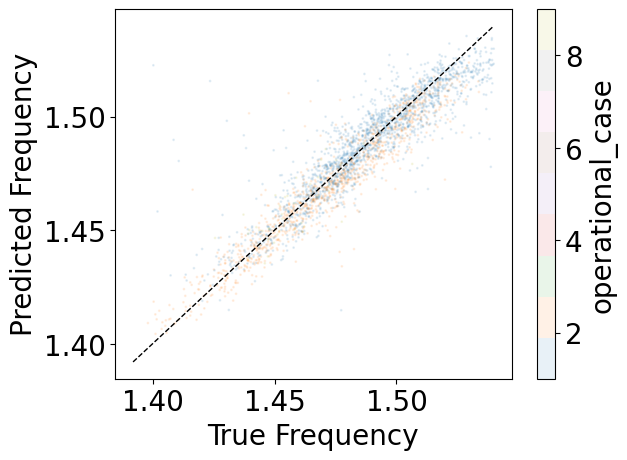

In [27]:
nn3_predictions = keras_nn3.predict(X_test_ts_prep)
nn3_mse = mean_squared_error(y_test_ts_prep, nn3_predictions)
nn3_r2 = r2_score(y_test_ts_prep, nn3_predictions)
print("NN MSE:", nn3_mse, "NN R2:", nn3_r2)

plt.plot(np.arange(y.values.min(),y.values.max(),0.001), np.arange(y.values.min(),y.values.max(),0.001), c='k', linestyle='--', linewidth=1)
plt.scatter(
    y_test_ts_prep, nn3_predictions, alpha=0.1, s=1,c=inputs[color_column].loc[y_test_ts_prep.index], cmap=cmap,
    )
plt.colorbar(label=color_column)
plt.xlabel('True Frequency')
plt.ylabel('Predicted Frequency')
plt.show()

# Hyperparameter tuning

In [28]:
import optuna 
def objective_cb(trial):
    params = {
        #"task_type" : "GPU",
        "iterations": trial.suggest_int("iterations", 500, 2000),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 10, log=True),
        "learning_rate": trial.suggest_float("learning_rate",0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        #"subsample": trial.suggest_float("subsample", 0.05, 1.0),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    model.fit(X_tr_ts, y_tr_ts)
    predictions = model.predict(X_test_ts)
    mse = mean_squared_error(y_test_ts, predictions, squared=True)
    return mse

study = optuna.create_study(direction='minimize', study_name='catboost_optimization')
study.optimize(objective_cb, n_trials=50, n_jobs=-1, timeout=600)

print(study.best_value)
print(study.best_params)

[I 2023-07-28 13:26:07,007] A new study created in memory with name: catboost_optimization
[I 2023-07-28 13:26:21,405] Trial 1 finished with value: 9.893905199392828e-05 and parameters: {'iterations': 601, 'l2_leaf_reg': 7.306949497282726, 'learning_rate': 0.020364082920939747, 'depth': 5}. Best is trial 1 with value: 9.893905199392828e-05.
[I 2023-07-28 13:26:35,555] Trial 2 finished with value: 8.763811274198158e-05 and parameters: {'iterations': 1329, 'l2_leaf_reg': 0.16920134589771987, 'learning_rate': 0.04546018125733392, 'depth': 5}. Best is trial 2 with value: 8.763811274198158e-05.
[I 2023-07-28 13:26:43,039] Trial 0 finished with value: 9.44249223061108e-05 and parameters: {'iterations': 848, 'l2_leaf_reg': 7.242746650502016, 'learning_rate': 0.01151843286287543, 'depth': 7}. Best is trial 2 with value: 8.763811274198158e-05.
[I 2023-07-28 13:26:55,065] Trial 9 finished with value: 9.022057761650392e-05 and parameters: {'iterations': 1356, 'l2_leaf_reg': 3.220652713459409, 'le

8.744233445859084e-05
{'iterations': 511, 'l2_leaf_reg': 0.6802885290928246, 'learning_rate': 0.05445124502312814, 'depth': 10}


In [29]:
best_params = study.best_params
cb_regr_opt = cb.CatBoostRegressor(**best_params)
cb_regr_opt.fit(X_tr_ts, y_tr_ts)

0:	learn: 0.0260364	total: 46.4ms	remaining: 23.7s
1:	learn: 0.0250116	total: 94.8ms	remaining: 24.1s
2:	learn: 0.0239828	total: 143ms	remaining: 24.2s
3:	learn: 0.0230883	total: 191ms	remaining: 24.2s
4:	learn: 0.0221609	total: 232ms	remaining: 23.5s
5:	learn: 0.0213157	total: 279ms	remaining: 23.5s
6:	learn: 0.0205181	total: 322ms	remaining: 23.2s
7:	learn: 0.0197469	total: 361ms	remaining: 22.7s
8:	learn: 0.0190399	total: 415ms	remaining: 23.1s
9:	learn: 0.0184055	total: 466ms	remaining: 23.4s
10:	learn: 0.0177947	total: 513ms	remaining: 23.3s
11:	learn: 0.0171915	total: 569ms	remaining: 23.7s
12:	learn: 0.0166685	total: 625ms	remaining: 23.9s
13:	learn: 0.0161493	total: 672ms	remaining: 23.9s
14:	learn: 0.0156823	total: 726ms	remaining: 24s
15:	learn: 0.0152330	total: 777ms	remaining: 24s
16:	learn: 0.0148027	total: 820ms	remaining: 23.8s
17:	learn: 0.0143909	total: 863ms	remaining: 23.6s
18:	learn: 0.0140580	total: 920ms	remaining: 23.8s
19:	learn: 0.0136998	total: 965ms	remaining

CB opt MSE: 8.744233445859084e-05 CB opt R2: 0.8843549771614534


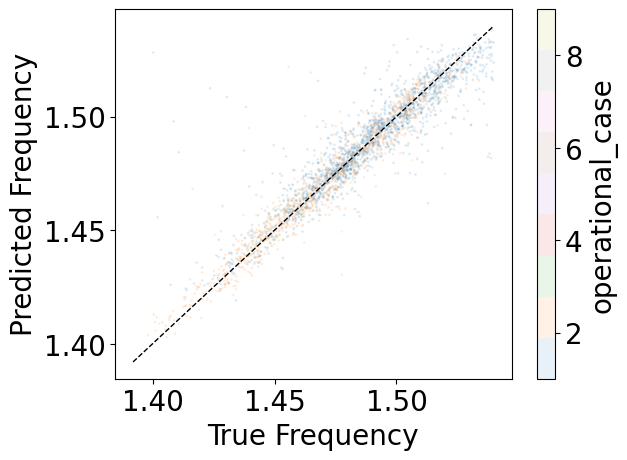

In [30]:
cb_regr_opt_predictions = cb_regr_opt.predict(X_test_ts)
cb_regr_opt_mse = mean_squared_error(y_test_ts, cb_regr_opt_predictions)
cb_regr_opt_r2 = r2_score(y_test_ts, cb_regr_opt_predictions)
print("CB opt MSE:", cb_regr_opt_mse, "CB opt R2:", cb_regr_opt_r2)

plt.plot(np.arange(y.values.min(),y.values.max(),0.001), np.arange(y.values.min(),y.values.max(),0.001), c='k', linestyle='--', linewidth=1)
plt.scatter(
    y_test_ts, cb_regr_opt_predictions, alpha=0.1, s=1,c=inputs[color_column].loc[y_test_ts.index], cmap=cmap,
    )
plt.colorbar(label=color_column)
plt.xlabel('True Frequency')
plt.ylabel('Predicted Frequency')
plt.show()

In [31]:
#Hyperparameter optimization

#Hyperopt functions for hyperparameter optimizations
from sklearn.pipeline import Pipeline
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from oma_tracking.models.utils import convert_dict
from oma_tracking.data.preprocessing import AngleTransformer, sin_cos_angle_inputs


XGB_optimizations = {}

seed = 24
def objective_xgb(space):
    model = Pipeline(
            steps=[
                ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                ('regressor', XGBRegressor(
                                 n_estimators = space['n_estimators'],
                                 max_depth = space['max_depth'],
                                 learning_rate = space['learning_rate'],
                                 colsample_bytree = space['colsample_bytree'],
                                 )
                )
            ]
        )
    score = cross_val_score(model,  X_tr_ts, y_tr_ts, cv=5, scoring='neg_mean_squared_error').mean()
    # We aim to maximize r2 score, therefore we return it as a negative value
    return {'loss': -score, 'status': STATUS_OK }

def optimize_xgb(trial):
    space = {
        'n_estimators':hp.uniformint('n_estimators',10,1000),
        'max_depth':hp.uniformint('max_depth',2,20),
        'learning_rate':hp.uniform('learning_rate',0.001,0.5),
        'colsample_bytree': hp.uniform('colsample_bytree',0.1, 1),
    }
    best = \
        fmin(
            fn = objective_xgb,
            space = space,
            algo = tpe.suggest,
            trials = trial,
            max_evals = 20,
            )
    return best
mode = 'SS1'
trial2=Trials()
XGB_optimizations[mode] = optimize_xgb(trial2)
XGB_optimizations[mode] = convert_dict(XGB_optimizations)[mode]

100%|██████████| 20/20 [06:48<00:00, 20.41s/trial, best loss: 0.00046896962736178943]


In [32]:
regr_xgb_optimized = \
                Pipeline(
                    steps=[
                        ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                        ('regressor', XGBRegressor(
                            n_estimators = XGB_optimizations[mode]['n_estimators'],
                            max_depth = XGB_optimizations[mode]['max_depth'],
                            learning_rate = XGB_optimizations[mode]['learning_rate'],
                            colsample_bytree = XGB_optimizations[mode]['colsample_bytree'],
                            )
                        )
                    ]
                )

regr_xgb_optimized.fit(X_tr_ts, y_tr_ts)

regr_xgb_optimized_pred = regr_xgb_optimized.predict(X_test_ts)
regr_xgb_optimized_mse = mean_squared_error(y_test_ts, regr_xgb_optimized_pred)
regr_xgb_optimized_r2 = r2_score(y_test_ts, regr_xgb_optimized_pred)
print("XGBRegressor Optimized MSE:", regr_xgb_optimized_mse, "XGBRegressor Optimized R2:", regr_xgb_optimized_r2)

XGBRegressor Optimized MSE: 0.00011383802416066513 XGBRegressor Optimized R2: 0.8494459121492295


In [33]:
#Hyperparameter optimization

#Hyperopt functions for hyperparameter optimizations

from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from oma_tracking.models.utils import convert_dict
RF_optimizations = {}

seed = 24
def objective_rf(space):
    model = Pipeline(
            steps=[
                ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                ('regressor', RandomForestRegressor(
                                 n_estimators = space['n_estimators'],
                                 max_depth = space['max_depth'],
                                 min_samples_split = space['min_samples_split'],
                                 )
                )
            ]
        )
    score = cross_val_score(model,   X_tr_ts, y_tr_ts, cv=5, scoring='neg_mean_squared_error').mean()
    # We aim to maximize r2 score, therefore we return it as a negative value
    return {'loss': -score, 'status': STATUS_OK }

def optimize_rf(trial):
    space = {
        'n_estimators': hp.uniformint('n_estimators',10,500),
        'max_depth': hp.uniformint('max_depth',2,20),
        'min_samples_split': hp.uniformint('min_samples_split',2,20)
    }
    best = \
        fmin(
            fn = objective_rf,
            space = space,
            algo = tpe.suggest,
            trials = trial,
            max_evals = 20,
            )
    return best
        
trial2=Trials()
RF_optimizations[mode] = optimize_rf(trial2)
RF_optimizations[mode] = convert_dict(RF_optimizations)[mode]

 10%|█         | 2/20 [08:10<1:13:35, 245.33s/trial, best loss: 0.0006264979277034795]


KeyboardInterrupt: 

In [ ]:
RF_optimizations[mode] = convert_dict(RF_optimizations)[mode]
regr_rf_optimized = \
                Pipeline(
                    steps=[
                        ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                        ('regressor', RandomForestRegressor(
                            n_estimators = RF_optimizations[mode]['n_estimators'],
                            max_depth = RF_optimizations[mode]['max_depth'],
                            min_samples_split = RF_optimizations[mode]['min_samples_split']
                            )
                        )
                    ]
                )

regr_rf_optimized.fit(X_tr_ts, y_tr_ts)

regr_rf_optimized_pred = regr_rf_optimized.predict(X_test_ts)
regr_rf_optimized_mse = mean_squared_error(y_test_ts, regr_rf_optimized_pred)
regr_rf_optimized_r2 = r2_score(y_test_ts, regr_rf_optimized_pred)
print("RandomForestRegressor Optimized MSE:", regr_rf_optimized_mse, "RandomForestRegressor Optimized R2:", regr_rf_optimized_r2)

KeyError: 'SS1'

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import keras_tuner
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import StandardScaler

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
        
    for i in range(num_hidden_layers):
        # Define the number of neurons for each hidden layer
        model.add(layers.Dense(
            units=hp.Int(f"units_{i}", min_value=8, max_value=128, step=8),
            activation="relu",
        ))
    
    model.add(layers.Dense(1, activation="linear"))
    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"],
    )
    return model

tuners = {}
for num_hidden_layers in range(1, 4):
    print(f"Number of hidden layers: {num_hidden_layers}")
    tuners[num_hidden_layers] = keras_tuner.BayesianOptimization(
        hypermodel=build_model,
        objective="mean_squared_error",
        max_trials=10,
        executions_per_trial=1,
        overwrite=True,
        directory="my_dir",
        project_name="nn_multiple_hidden_layers",
    )
    tuners[num_hidden_layers].search_space_summary()

    tuners[num_hidden_layers].search(X_tr_ts_prep, y_tr_ts, epochs=50, validation_data=(X_test_ts_prep, y_test_ts))
    best_nn = tuners[num_hidden_layers].get_best_models()[0]
    best_nn.build(input_shape=(1, X_tr_ts_prep.shape[1]))
    best_nn.fit(X_tr_ts_prep, y_tr_ts, epochs=100, validation_data=(X_test_ts_prep, y_test_ts))

    best_nn_pred = best_nn.predict(X_test_ts_prep)
    best_nn_mse = mean_squared_error(y_test_ts, best_nn_pred)
    best_nn_r2 = r2_score(y_test_ts, best_nn_pred)
    print("NN Optimized MSE:", best_nn_mse, "NN Optimized R2:", best_nn_r2)


Number of hidden layers: 1
Search space summary
Default search space size: 1
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
128               |?                 |units_0

Epoch 1/50
12011/12011 [==============================] - 28s 2ms/step - loss: 3.1416e-04 - mean_squared_error: 3.1416e-04 - val_loss: 2.2953e-05 - val_mean_squared_error: 2.2953e-05
Epoch 2/50
12011/12011 [==============================] - 31s 3ms/step - loss: 1.3730e-05 - mean_squared_error: 1.3730e-05 - val_loss: 8.0859e-06 - val_mean_squared_error: 8.0859e-06
Epoch 3/50
11979/12011 [============================>.] - ETA: 0s - loss: 8.1237e-06 - mean_squared_error: 8.1237e-06